# LAB 1: Metric Algorithms
### AI and Machine Learning // Suchkova Natalia М8О - 114М - 22
17.03.23 @ MAI IT-Center

## The Task
1. Применить метод K ближайших соседей  (KNN ядерный), взвешенный алгоритмом STOLP для пяти классов, сгенерированных с помощью MakeClassification

2. (*) Для сгенерированного датасета создать профиль компактности

3. Для сгенерированного датасета, произвести оптимизацию по выбору ширины окна (или метод меняющегося окна)

4. Найти датасет с картинками (2-3 класса) небольшой (100 картинок достаточно, классифицированных). Найти метод\библиотеку для построения embedding (векторизации) изображений. Применить этот метод на картинки. Применить КNN (без оптимизации) для полученного датасета из векторизованных картинок.

5. (*) Задание 4 со своими фотографиями.

## Table of Contents


1. [**KNN**](#g1)


2. [**STOLP**](#g2)


3. [**Метод окна Парзена для KNN**](#g3)

    - [](#g4)
    
    - [](#g3)
    
    - [](#g2)


4. [**Профиль компактности**](#g4)

    - [](#g6)
    
    - [](#g7)
    
    - [](#g8)
    
    
5. [**KNN для векторизованных картинок**](#g5)
    
    - [](#g10)


6. [**Свои картинки**](#g6)
    
    - [](#g11)
    
    - [](#g90)
    

## Задание 1.

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
from mlxtend.plotting import plot_decision_regions

from typing import Mapping
import math

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors


from scipy.spatial import KDTree

In [2]:
seed = np.random.seed(11)

#### Генерим данные

In [159]:
X, Y = make_classification(n_samples=1000, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=seed)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=seed)

### KNN

In [305]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=6)

In [306]:
predictions = model.predict(X_test)

In [282]:
model.kneighbors(X_test, return_distance=False)

array([[575, 756, 204, 515, 552, 725],
       [772, 428, 422, 496, 571, 704],
       [222, 473, 419, 128, 390, 314],
       ...,
       [650, 795, 121, 151, 438,  31],
       [141, 777, 155, 438, 634, 693],
       [357, 707, 706, 678, 165, 418]], dtype=int64)

In [307]:
model.kneighbors(X_test[5].reshape(1, -1), return_distance=False)

array([[162, 685, 389, 289, 210,  27]], dtype=int64)

In [98]:
def plot(data, preds, title, marker='o', size=30):
    colors = ['#FF5733', '#BFFF4B', '#5966DA', '#FFC300', '#D859DA']
    c = [colors[i] for i in preds]
    fig = plt.figure()
    ax = fig.add_subplot(111, 
                         projection='3d'
                        )
    ax.set_title(title)
    ax.scatter(data[ : , 0], 
               data[ : , 1], 
               data[ : , 2], 
               c=c, marker=marker,
               s=size)
    plt.show()
    
    
def plot_compare(data, labels, lbl_preds, size=60, title=''):
    
    colors = ['#FF5733', '#BFFF4B', '#5966DA', '#FFC300', 
              '#D859DA', '#DAF7A6', '#4BFCFF', '#581845']
    
    fig = plt.figure(figsize=plt.figaspect(0.3))
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_title('Реальные значения')
    c = [colors[i] for i in labels]
    ax1.scatter(data[ : , 0], 
                data[ : , 1], 
                data[ : , 2], 
                c=c, s=size)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title(f'Наши предсказания {title}')
    c = [colors[i] for i in lbl_preds]
    ax2.scatter(data[ : , 0], 
                data[ : , 1], 
                data[ : , 2], 
                c=c, s=size)
    
    plt.show()

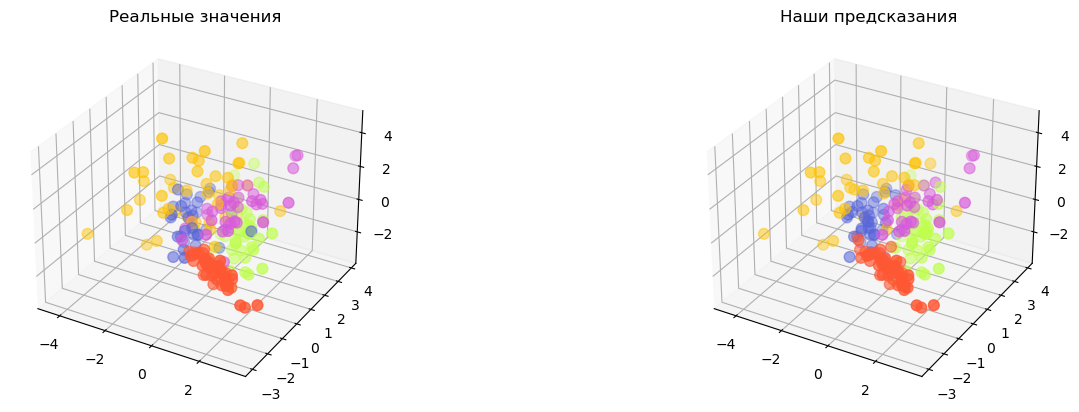

In [99]:
plot_compare(X_test, Y_test, predictions)

In [100]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90        45
           1       0.81      0.85      0.83        41
           2       0.65      0.76      0.70        34
           3       0.86      0.72      0.78        43
           4       0.90      0.73      0.81        37

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.82      0.81      0.81       200



### STOLP  
— алгоритм отбора эталонных объектов для метрического классификатора.

Пусть дана обучающая выборка $X^l=(x_i, y_i)_{i=1}^l$, где $x_i$ — объекты, $y_i=y^*(x_i)$ — классы, которым принадлежат эти объекты. 

Кроме того, задана метрика $\rho \: X \times X \rightarrow \mathbb{R}$, такая, что выполняется гипотеза компактности. 

При классификации объектов метрическим классификатором $$a(u, X^l) = \mathrm{arg}\max_{y\in Y} \Gamma_y (u, X^l) = \mathrm{arg}\max_{y\in Y} \sum_{i=1}^l[y_u^(i)=y]w(i, u),$$ например, `методом ближайших соседей` необходимо вычислять расстояния от классифицируемого объекта до всех объектов обучающей выборки. 

Минусы: Время, затрачиваемое на это для каждого классифицируемого объекта, пропорционально размеру обучающей выборки. Кроме того, оказывается необходимым хранить большой объем данных.

Но не все объекты обучающей выборки равноценны. 

Среди них есть
- наиболее типичные представители классов, то есть **эталоны**; 
- **неинформативные объекты**, при удалении которых из обучающей выборки качество классификации не изменится;
- **выбросы, или шумовые объекты** — объекты, находящиеся в гуще «чужого» класса, только ухудшающие качество классификации.

Поэтому необходимо уменьшить объем обучающей выборки, оставив в ней только эталонные объекты для каждого класса.

**Oтступ (margin)** показывает насколько истинный класс далеко от другого класса. Отступ объекта показывает нам, насколько глубоко текущий объект лежит в пределах своего класса. Например, если почти все ближайшие соседи некоторого объекта x_i принадлежат к тому же классу, что и сам x_i, мы можем сказать, что у него очень положительный отступ. С другой стороны, если почти все ближайшие соседи принадлежат к другому классу, чем x_i, отступ должен быть отрицательным. Мы можем вычислить маржу таким образом: в случае, если отступ положительный, то предсказание является верным. В случае, если отступ отрицательный, то предсказание является ошибочным.

Но для начала нужно сделать несколько шагов:

1. Для каждого элемента выборки найти сумму евклидового расстояния до ближайших n соседей;

2. Отсортировать элементы выборки по сумме расстояний;

3. Взять первые N элементов - они и будут эталонными объектами.

https://jet1black.wordpress.com/2015/10/03/stolp-algorithm-implementation/

In [338]:
def compute_margins(xkd, x, y, u, u_ans, n_neigh):
    result = []
    bound = min(n_neigh, y.shape[0]) # задаем количество ближайших соседей для исследования
    
    for cur_u_idx, cur_u_coord in enumerate(u):  # задаем индекс каждой точке в u
        idx = xkd.kneighbors(cur_u_coord.reshape(1, -1), return_distance=False)
        idx = idx.tolist()[0]  # сохраняем индексы ближайших соседей
        maj = {}
        
        for i in idx:
            y_cur = y[i]  # перебираем все класс в ближайших соседях по их индексу
            di = np.linalg.norm(cur_u_coord - x[i])  # расстояние от текущей точки до каждой точки в данных
            dn = np.linalg.norm(cur_u_coord - x[idx[bound - 1]])  # расстояние от текущей точки до предыдущей из n соседей
            w = 0.0
            
            if di != 0.0 and dn > di:
                w = dn / di
                
            maj[y_cur] = maj.get(y_cur, 0) + w  # обновляем в словаре по индексу точки ее вес, 
                                                # если новая точка, то ее вес 0 сначала
            
        cur_u_ans = u_ans[cur_u_idx] # находим в Y_train по текущему индексу класс [u_ans[cur_u_idx]][0]
        correct_score = maj.get(cur_u_ans, 0)  # достаем из словаря вес точки
        del maj[cur_u_ans]
        
        max_wrong = 0
        if len(maj) > 0:
            max_wrong = sorted(maj.items(), key=lambda x: x[1])[-1][1] # находим максимально отдаленный элемент (точку)
            
        result.append(correct_score - max_wrong)  # для рассчета конечной удаленности вычитаем самый большой отступ
        
    return np.array(result)

def compute_margins(xkd, x, y, u, u_ans, n):
    result = []
    bound = min(n, y.shape[0]) # задаем количество ближайших соседей для исследования
    
    for cur_u_idx, cur_u_coord in enumerate(u):  # задаем индекс каждой точке в u
        idx = xkd.query(cur_u_coord, bound)[1]  # сохраняем индексы ближайших соседей
        maj = {}
        
        for i in idx:
            y_cur = y[i]  # перебираем все класс в ближайших соседях по их индексу
            di = np.linalg.norm(cur_u_coord - x[i])  # расстояние от текущей точки до каждой точки в данных
            dn = np.linalg.norm(cur_u_coord - x[idx[bound - 1]])  # расстояние от текущей точки до предыдущей из n соседей
            w = 0.0
            
            if di != 0.0 and dn > di:
                w = dn / di
                
            maj[y_cur] = maj.get(y_cur, 0) + w  # обновляем в словаре по индексу точки ее вес, 
                                                # если новая точка, то ее вес 0 сначала
            
        cur_u_ans = u_ans[cur_u_idx] # находим в Y_train по текущему индексу класс [u_ans[cur_u_idx]][0]
        correct_score = maj.get(cur_u_ans, 0)  # достаем из словаря вес точки
        del maj[cur_u_ans]
        
        max_wrong = 0
        if len(maj) > 0:
            max_wrong = sorted(maj.items(), key=lambda x: x[1])[-1][1] # находим максимально отдаленный элемент (точку)
            
        result.append(correct_score - max_wrong)  # для рассчета конечной удаленности вычитаем самый большой отступ
        
    return np.array(result)

In [376]:
model = KNeighborsClassifier(n_neighbors=7).fit(X_test, Y_test)

In [377]:
margins = compute_margins(model, X_test, Y_test, X_test, Y_test, 7)

# def compute_margins(xkd, x, y, u, u_ans, n):  мы считаем отступ для всех точек, поэтому у нас х и и это одно и то же
margins = compute_margins(KDTree(X_test), X_test, Y_test, X_test, Y_test, 5)

In [341]:
len(margins)

200

In [385]:
def stolp(src_x, src_y, err_num, depth_limit, n):

    support_x = []
    support_y = []
    src_xkd = KNeighborsClassifier(n_neighbors=n).fit(src_x, src_y)
    print(src_xkd)
    margins = np.array([compute_margins(src_xkd, src_x, src_y, src_x, src_y, n)]).transpose()
    
    x = src_x[margins[:, 0] > depth_limit]
    y = src_y[margins[:, 0] > depth_limit]
    margins = margins[margins[:, 0] > depth_limit]
    sorted_margs = np.argsort(margins[:, 0])

    for ans in np.unique(y):
        for m in sorted_margs:

            if y[m] == ans:

                support_x.append(x[m])
                support_y.append(y[m])
                x = np.delete(x, (m), axis=0)
                y = np.delete(y, (m), axis=0)
                break
                
    errors = x.shape[0]
#     print(support_x, support_y)
    while errors > err_num:
        xkd = KNeighborsClassifier(n_neighbors=n).fit(np.array(support_x), np.array(support_y))
        margins = compute_margins(xkd, np.array(support_x), np.array(support_y), x, y, n)
        KNN_preds = model.predict(support_x)

        errors = len(KNN_preds[KNN_preds == src_y[:len(KNN_preds)]])
        sorted_margs = np.argsort(margins)  # выводим индексы отсортированных отступов
        to_delete = []
        min = sorted_margs[0]
        support_x.append(x[min])
        support_y.append(y[min])
        to_delete.append(min)
        
        x = np.delete(x, to_delete, axis=0)
        y = np.delete(y, to_delete, axis=0)
        
    return np.array(support_x), np.array(support_y)

def stolp(src_x, src_y, err_num, depth_limit, n):

    support_x = []
    support_y = []
    src_xkd = KDTree(src_x)
    print(src_xkd)
    margins = np.array([compute_margins(src_xkd, src_x, src_y, src_x, src_y, n)]).transpose()
    
    x = src_x[margins[:, 0] > depth_limit]
    y = src_y[margins[:, 0] > depth_limit]
    margins = margins[margins[:, 0] > depth_limit]
    sorted_margs = np.argsort(margins[:, 0])

    for ans in np.unique(y):
        for m in sorted_margs:

            if y[m] == ans:

                support_x.append(x[m])
                support_y.append(y[m])
                x = np.delete(x, (m), axis=0)
                y = np.delete(y, (m), axis=0)
                break
                
    errors = x.shape[0]
    
    while errors > err_num:
        xkd = KDTree(np.array(support_x))
        margins = compute_margins(xkd, np.array(support_x), np.array(support_y), x, y, n)
        KNN_preds = model.predict(support_x)

        errors = len(KNN_preds[KNN_preds == src_y[:len(KNN_preds)]])
        sorted_margs = np.argsort(margins)  # выводим индексы отсортированных отступов
        to_delete = []
        min = sorted_margs[0]
        support_x.append(x[min])
        support_y.append(y[min])
        to_delete.append(min)
        
        x = np.delete(x, to_delete, axis=0)
        y = np.delete(y, to_delete, axis=0)
        
    return np.array(support_x), np.array(support_y)

In [382]:
stolp_prx, stolp_pry = stolp(X_test, Y_test, err_num=60, depth_limit=0.0001, n=5)

KNeighborsClassifier()


In [383]:
stolp_prx

array([[ 0.16234674,  0.46846048, -0.7784959 ],
       [ 1.3015293 ,  1.30024013,  1.0617255 ],
       [ 1.72208996, -1.08737766, -2.31885603],
       [-0.9403541 ,  0.21330502,  1.14653194],
       [-1.33225733, -1.9046816 , -0.76541665],
       [-0.36746711,  0.25132244, -0.78868313]])

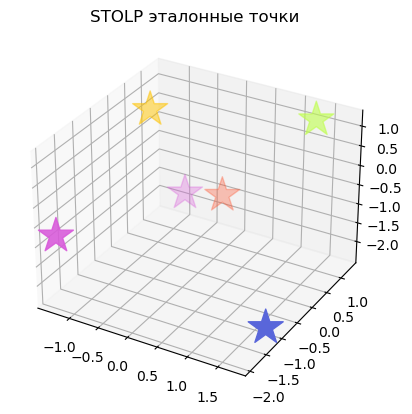

In [384]:
plot(stolp_prx, stolp_pry, 'STOLP эталонные точки', '*', 700)

### Профиль компактности

Профиль компактности выборки в метрических алгоритмах классификации — функция R(j), выражающая долю объектов выборки, для которых правильный ответ не совпадает с правильным ответом на j-м соседе.

Рассматривается задача классификации. Имеется множество объектов X и множество имён классов Y. Задана обучающая выборка пар «объект—ответ» $X^m = \{(x_1,y_1),\ldots,(x_m,y_m)\} \in X\times Y$.

Пусть на множестве объектов задана функция расстояния $\rho(x,x')$. Эта функция должна быть достаточно адекватной моделью сходства объектов. Чем меньше значение этой функции, тем более схожи объекты $x,x'$.

Для произвольного объекта $u$ расположим объекты обучающей выборки $x_i$ в порядке возрастания расстояний до $u$:

$$\rho(u,x_{1; u}) \leq  \rho(u,x_{2; u}) \leq \cdots \leq \rho(u,x_{m; u}),$$
где через $x_{i; u}$ обозначается элемент обучающей выборки, который является i-м соседом объекта $u$. Аналогичное обозначение введём и для ответа на i-м соседе: $y_{i; u}$. Каждый объект $u\in X$ порождает свою перенумерацию выборки.

Рассматривается метод ближайшего соседа, который относит классифицируемый объект $u$ к тому классу, которому принадлежит ближайший к $u$ объект обучающей выборки:

$a(u,X^m) = y_{1;u}$.

Профиль компактности выборки $X^m$ есть функция

$$R(j,X^m) = \frac1m \sum_{i=1}^m \left[ y_i \neq y_{j;x_i} \right]$$
Иными словами, профиль компактности R(j) — это доля объектов выборки, для которых j-й сосед лежит в другом классе.


Профиль компактности является формальным выражением гипотезы компактности — предположения о том, что схожие объекты гораздо чаще лежат в одном классе, чем в разных. *Чем проще задача, то есть чем чаще близкие объекты оказываются в одном классе, тем сильнее «прижимается к нулю» начальный участок профиля. В сложных задачах или при неудачном выборе функции расстояния ближайшие объекты практически не несут информации о классах, и профиль вырождается в константу, близкую к 0.5.*

На рисунке показаны профили компактности для серии плоских модельных задач классификации с двумя классами. Чем ниже проходит начальный участок профиля, тем выше обобщающая способность метода ближайшего соседа.

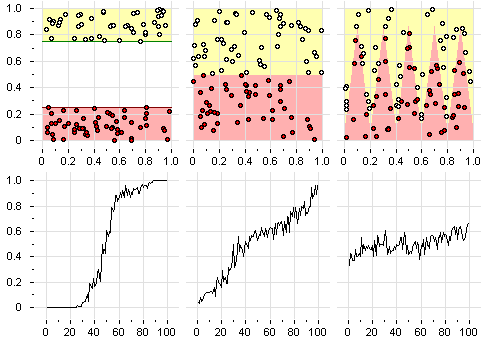

In [160]:
def compactness_profile(index:int, X, y, metric='euclidean'):
    """
    index: индекс
    X: матрица объект-признак, для которой хотим посчитать профиль компактности
    y: вектор таргетов для этих объектов
    metric: ['euclidean', 'cosine', ...]
    """
    assert 0 <= index <= X.shape[0]
    neigh = NearestNeighbors(n_neighbors=X.shape[0], metric=metric)
    neigh.fit(X, y)
    distances, indexes = neigh.kneighbors(X)
    return (y != y[indexes[:, index]]).mean() # возвращаем значения для профиля компактности

In [238]:
length = np.array(list(range(1, X_train.shape[0])))
comp_vals = np.array([compactness_profile(i, X_train, Y_train) for i in length])

fig = px.line(x=length, y=comp_vals)
fig.show()

### Parzen Window Method

Восстановление плотности методом Парзена-Розенблатта
$$p(x)= \frac{1}{n}\displaystyle\sum_{i=1}^n \frac{1}{h^2} \phi \big(\frac{x_i−x_h}{h}\big)$$ - where n is number of elements in the vector, x is a vector, p(x) is a probability density of x, h is dimension of the Parzen Window, and $\phi$ is a window function.

In [119]:
gauss_kernel = lambda x: ((2 * math.pi) ** (-1/2)) * np.exp(-1/2 * (x ** 2))

In [120]:
distance = lambda point1, point2: math.sqrt((point1[0] - point2[0]) ** 2 \
                                            + (point1[1] - point2[1]) ** 2 \
                                            + (point1[2] - point2[2]) ** 2
                                           )

In [121]:
def ParzRos_score(x: float, h: float, data: np.array, kernel: Mapping, distance: Mapping) -> float:
    """
    Function: 
        Метод возвращает значение, найденное методом Парзена-Розенблатта для группы точек.

    Args: 
        x: float - параметр функции ядра.
        h: float - параметр метода Парзена-Розенблатта: ширина окна.
        data: list или array - набор точек.
        kernel: Mapping - тип ядра.
        distance: Mapping - функция расчета расстояния между двумя точками 
                        на плоскости или в пространстве (для нелинейной задачи).

    Return:
        Значение найденное методом Парзена-Розенблатта для группы точек (float).
    """
    return sum([kernel(distance(x, point) / h) for point in data]) / (len(data) * h)

#### Функция ядра (окна)
$K(z)$ — произвольная четная функция, называемая функцией ядра или окна. Термин окно происходит из классического вида функции:

$K(z) = \frac12 [|z| < 1]$

#### Ширина окна
Ширина окна сильно влияет на качество восстановления плотности и, как следствие, классификации. При слишком малом окне мы получаем тот же эффект, что и при использовании гистограммы значений. При слишком большом окне плотность вырождается в константу.

Для нахождения оптимальной ширины окна удобно использовать принцип максимума правдоподобия с исключением объектов по одному (leave-one-out, LOO).

#### Возможные проблемы
*Проблема локальных сгущений*

Возникает в тех случаях, когда распределение объектов в пространстве сильно неравномерно, и одно и то же значение ширины окна h приводит к чрезмерному сглаживанию плотности в одних местах, и недостаточному сглаживанию в других. Проблему решают окна переменной ширины.

*Проблема «проклятия размерности»*

Если число признаков велико и учитываются все они, то все объекты оказываются примерно на одинаковом расстоянии друг от друга. Выход заключается в понижении размерности с помощью преобразования пространства признаков, либо путём отбора информативных признаков.

In [114]:
def ParzWindow(distance: Mapping, h: float) -> float:
    """
    Function: 
        Метод возвращает значение, найденное методом окна Парзена для группы точек.

    Args: 
        distance: Mapping - расстояния между двумя точками 
                на плоскости или в пространстве.
        h: float - параметр метода Парзена: ширина окна.

    Return:
        Значения найденные методом окна Парзена для группы точек (float).
    """
    return (1 - (np.array(distance) / h) ** 2) * (np.abs(np.array(distance) / h) <= 1)

`def hypercube_kernel(h, x, x_i):
    """
    Implementation of a hypercube kernel for Parzen-window estimation.

    Keyword arguments:
        h: window width
        x: point x for density estimation, 'd x 1'-dimensional numpy array
        x_i: point from training sample, 'd x 1'-dimensional numpy array

    Returns a 'd x 1'-dimensional numpy array as input for a window function.

    """
    assert (x.shape == x_i.shape), 'vectors x and x_i must have the same dimensions'
    return (x - x_i) / (h) -->


def parzen_window_func(x_vec, h=1):
    """
    Implementation of the window function. Returns 1 if 'd x 1'-sample vector
    lies within inside the window, 0 otherwise.

    """
    for row in x_vec:
        if np.abs(row) > (1/2):
            return 0
    return 1


def parzen_estimation(x_samples, point_x, h, d, window_func, kernel_func):
    """
    Implementation of a parzen-window estimation.

    Keyword arguments:
        x_samples: A 'n x d'-dimensional numpy array, where each sample
            is stored in a separate row. (= training sample)
        point_x: point x for density estimation, 'd x 1'-dimensional numpy array
        h: window width
        d: dimensions
        window_func: a Parzen window function (phi)
        kernel_function: A hypercube or Gaussian kernel functions

    Returns the density estimate p(x).

    """
    k_n = 0
    for row in x_samples:
        x_i = kernel_func(h=h, x=point_x, x_i=row[:, np.newaxis])
        k_n += window_func(x_i, h=h)
    return (k_n / len(x_samples)) / (h ** d)`

In [125]:
model_parz = KNeighborsClassifier(n_neighbors=3,
                                 weights=lambda x: ParzWindow(x, h=0.7)
                              #ParzRos_score(x, 0.05, X_train, gauss_kernel, distance)
                             )
model_parz.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3,
                     weights=<function <lambda> at 0x000001934DBCEAF8>)

In [126]:
predictions_parz = model_parz.predict(X_test)

In [127]:
predictions_parz

array([1, 1, 0, 0, 0, 2, 3, 2, 3, 1, 1, 2, 0, 0, 1, 4, 1, 3, 0, 3, 1, 1,
       1, 0, 0, 1, 4, 0, 3, 4, 0, 4, 2, 3, 3, 3, 4, 0, 0, 1, 4, 2, 3, 4,
       0, 3, 3, 2, 4, 1, 2, 4, 1, 1, 2, 0, 2, 0, 0, 4, 3, 2, 1, 1, 2, 2,
       0, 1, 2, 3, 1, 0, 3, 2, 3, 4, 1, 2, 0, 1, 2, 4, 0, 0, 2, 0, 1, 1,
       1, 3, 1, 4, 1, 2, 2, 4, 1, 0, 4, 2, 3, 0, 2, 2, 1, 0, 2, 1, 0, 3,
       4, 3, 4, 0, 3, 4, 0, 3, 0, 2, 2, 0, 2, 0, 3, 1, 1, 4, 0, 1, 0, 1,
       1, 2, 1, 3, 2, 2, 2, 1, 3, 0, 2, 0, 1, 1, 0, 0, 0, 1, 4, 3, 3, 0,
       1, 0, 3, 1, 4, 1, 0, 1, 0, 2, 2, 4, 3, 0, 0, 2, 1, 1, 0, 0, 4, 0,
       0, 3, 1, 1, 4, 3, 0, 3, 2, 4, 4, 3, 3, 1, 0, 1, 4, 0, 4, 0, 4, 3,
       1, 3])

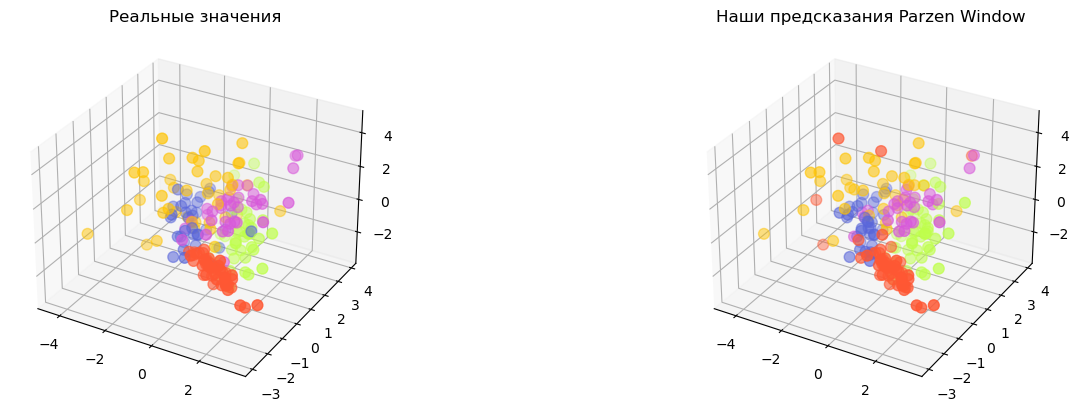

In [128]:
plot_compare(X_test, Y_test, predictions_parz, title='Parzen Window')

###  KNN для векторизованных картинок

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
        shading="auto",
    )

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=iris.target_names[y],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )

plt.show()

ImportError: cannot import name 'DecisionBoundaryDisplay' from 'sklearn.inspection' (C:\ProgramData\Anaconda3\lib\site-packages\sklearn\inspection\__init__.py)

In [259]:
!conda update scikit-learn

^C


In [265]:
!python3 -m pip install --upgrade --user scikit-learn

SyntaxError: invalid syntax (<ipython-input-265-d15c67225408>, line 1)

### Свои картинки